# Generating Spectra

In [1]:
import numpy as np
import time
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
import pylab as plt
import scipy
from scipy import ndimage

# ----------------------------------------------------------------------------------------------------------- #
####### PARAMETERS -- USER INPUT -- VALUES BELOW ARE FOR AU Mic b
# ----------------------------------------------------------------------------------------------------------- #

Rp        = 0.363*nc.r_jup_mean     # Planet radius [cm] 
Rs        = 0.75*nc.r_sun           # Stellar radius [cm] (planet and stellar radius from: https://arxiv.org/abs/2006.13248) 
Mass      = 11.7*nc.m_earth         # Planet mass [g] (mass estimate from: https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.3060Z/abstract)
gravity   = (nc.G*Mass)/(Rp**2)     # Planet surface gravity [cgs]
P0        = 0.01                    # Reference pressure [bar]
Teq       = 593                    # Planet equilibrium temperature [K] -- Isothermal model
mmw       = 2.353                   # Mean molecular weight [cgs]
#fact      = 0.01                   # Multiplicative factor to extend the wavelength ranges for petitRADTRANS
                                   # e.g., fact = 0.01 means that the wavelength range is 1% larger than the  min/max wavelengths in the input wave file
#Guillot Temperature profile parameters
kappa_IR = 0.03                    # Atmospheric opacity in IR wavelengths (cross-section per unit mass)
gamma = 0.032                        # Ratio between optical and IR opacity 
T_int = 200.                       # Planetary internal temperature [K] -- Guillot model
T_equ = 593.                      # Atmospheric Equilibrium Temperature (External) [K] -- Guillot model
    
    
pressures                    = np.logspace(-10, 2, 130)           # Pressure grid [bar] 

### Abundances in MASSIVE FRACTIONS 
abundances                   =  {}
abundances['H2']             =  0.71 * np.ones_like(pressures)
abundances['He']             =  0.27 * np.ones_like(pressures)
abundances['H2O_main_iso']   =  0.004 * np.ones_like(pressures)
abundances['CO_all_iso']     =  0.012* np.ones_like(pressures)
#abundances['NH3']            =  2.2e-5* np.ones_like(pressures)
#abundances['CO2']            =  1.0e-5* np.ones_like(pressures)
#abundances['CH4']            =  3.4e-4* np.ones_like(pressures)
#abundances['HCN']            =  1.1e-4* np.ones_like(pressures)

#abundances['CO_all_iso']     = 0.012* np.ones_like(pressures)
abundances['NH3_main_iso']   = 2.2 * 10**(-5) * np.ones_like(pressures)
abundances['CO2_main_iso']   = 1.0 * 10**(-5) * np.ones_like(pressures)
abundances['CH4_main_iso']   = 3.4*10**(-4) * np.ones_like(pressures)
abundances['HCN_main_iso']   = 1.1*10**(-4)* np.ones_like(pressures)

#Temp profile can be 'Isothermal' or 'Guillot' (Guillot is default)

# Min/Max wavelength in nm

#LS is a list containing all species to be simulated, available species (on my computer anyway) are below

#LS = ['H2O_main_iso','CO_all_iso','NH3_main_iso','CO2_main_iso','CH4_main_iso','HCN_main_iso', 'Na', 'K']

# may have to add input for defining the instrument used (spirou/igrins) for showing diffraction grating orders

def generate_spectra(LS, min_wavelength, max_wavelength, temp_profile='Guillot'):
#    t0 = time.time()
#    print("Init model")
    if temp_profile=='Isothermal':
        temperature  = Teq * np.ones_like(pressures)
    elif temp_profile=='Guillot':
        temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
    
    MMW          = mmw * np.ones_like(temperature)
    
    ### make model
    atmosphere = Radtrans(line_species = LS, \
                  rayleigh_species = ['H2', 'He'], \
                  continuum_opacities = ['H2-H2', 'H2-He'], \
                  wlen_bords_micron = [min_wavelength/1000.,max_wavelength/1000.], \
                  mode = 'lbl')
    
    atmosphere.setup_opa_structure(pressures)
    atmosphere.calc_transm(temperature,abundances,gravity,MMW,R_pl=Rp,P0_bar=P0)
    atmosphere.calc_flux(temperature, abundances, gravity, MMW)
    
    Rp_l = atmosphere.transm_rad     # Radius as function of wavelength
    Wm   = nc.c/atmosphere.freq/1e-7 #nm
    flux_variation = 1-((Rp_l**(2))/Rs**(2))    #Calculate the variation of flux

    # Various plots, comment out if necessary
    
    print("Plot of Transit radius:")
    plt.figure(figsize=[20,12])
    plt.plot(Wm, atmosphere.transm_rad/nc.r_jup_mean)
    #plt.xscale('log')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
    plt.show()
    plt.clf()    
    
    print("Transmission spectrum (Raw Flux):")
    plt.figure(figsize=[20,12])
    plt.plot(Wm, atmosphere.flux/1e-6)
    #plt.xscale('log')
    #plt.xlim([1.6e3,1.61e3])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
    plt.show()
    plt.clf()
    
 # PERHAPS MAKE A SEPARATE FUNCTION FOR NORMALISATION? IF NEED TO CHANGE THINGS IE PARAMS
# OF NORMALISATION I WILL HAVE TO REDO WHOLE FUNCTION
    
#---- Normalisation ------
    flux_variation = 1-((Rp_l**(2))/Rs**(2))
    
    spirou_min = []
    spirou_max = []
    
    spirou = open("orders_spirou.dat", "r")
    spirou.readline()
    for line in spirou:
        values = line.split()
        spirou_min.append(values[2])
        spirou_max.append(values[3])
        
    wavelength_min = np.amin(Wm)
    wavelength_max = np.amax(Wm)
    orders_min = []
    orders_max = []

    for value in spirou_min:
        if float(value) > wavelength_min and float(value) < wavelength_max:
            orders_min.append(float(value))
    for value in spirou_max:
        if float(value) > wavelength_min and float(value) < wavelength_max:
            orders_max.append(float(value))
    
    print("Unnormalised Transmission Spectrum")    
    
    # Note that the orders overlap, so the max and min adjacent to each other don't define an order, the orders overlap and cover ~50nm
    plt.figure(figsize=[20,12])    
    plt.plot(Wm, flux_variation, label='Spectrum')
    plt.vlines(orders_min, ymin= np.amin(flux_variation), ymax=np.amax(flux_variation), colors='red', linestyles='dashed', label='Minimum of order')
    plt.vlines(orders_max, ymin= np.amin(flux_variation), ymax=np.amax(flux_variation), colors='green', linestyles='dashed', label='Maximum of order')
    #plt.xscale('log')
    #plt.xlim([1.5e3, 1.7e3])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(r'Unnormalised Radius')
    plt.legend()
    plt.title('Unnormalised Transmission Spectrum showing maximum and minimum of diffraction grating orders')
    plt.show()
    plt.clf()
    
    # Using maximum_filter function to normalise data
    # Lower the footprint if necessary
    
    maximum = scipy.ndimage.maximum_filter(flux_variation, 1000)
    normalised_max = flux_variation/maximum
    
    print("Normalised Transmission Spectrum")
    plt.figure(figsize=[20,12])
    plt.plot(Wm, normalised_max, label='Spectrum')
    plt.vlines(orders_min, ymin= np.amin(normalised_max), ymax=np.amax(normalised_max), colors='red', linestyles='dashed', label='Minimum of order')
    plt.vlines(orders_max, ymin= np.amin(normalised_max), ymax=np.amax(normalised_max), colors='green', linestyles='dashed', label='Maximum of order')

    #plt.xscale('log')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(r'Normalised Radius')
    plt.title('Normalised Transmission Spectrum showing maximum and minimum of diffraction grating orders')
    plt.legend()
    plt.show()
    plt.clf()
        
#    save = input("Save data? (Will save final normalised spectrum and data for that plot) [Y/N]")
#    if save == "N":
#        break
#    elif save== "Y":
#NEED TO PUT SAVEFIG BEFORE plt.show() FOR IT TO SAVE.. BUT THEN CAN ONLY SAVE BEFORE SEEING THE PLOT
#        plt.savefig('')
        
    
    
    
    
    
    

  Read line opacities of CO_all_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Plot of Transit radius:


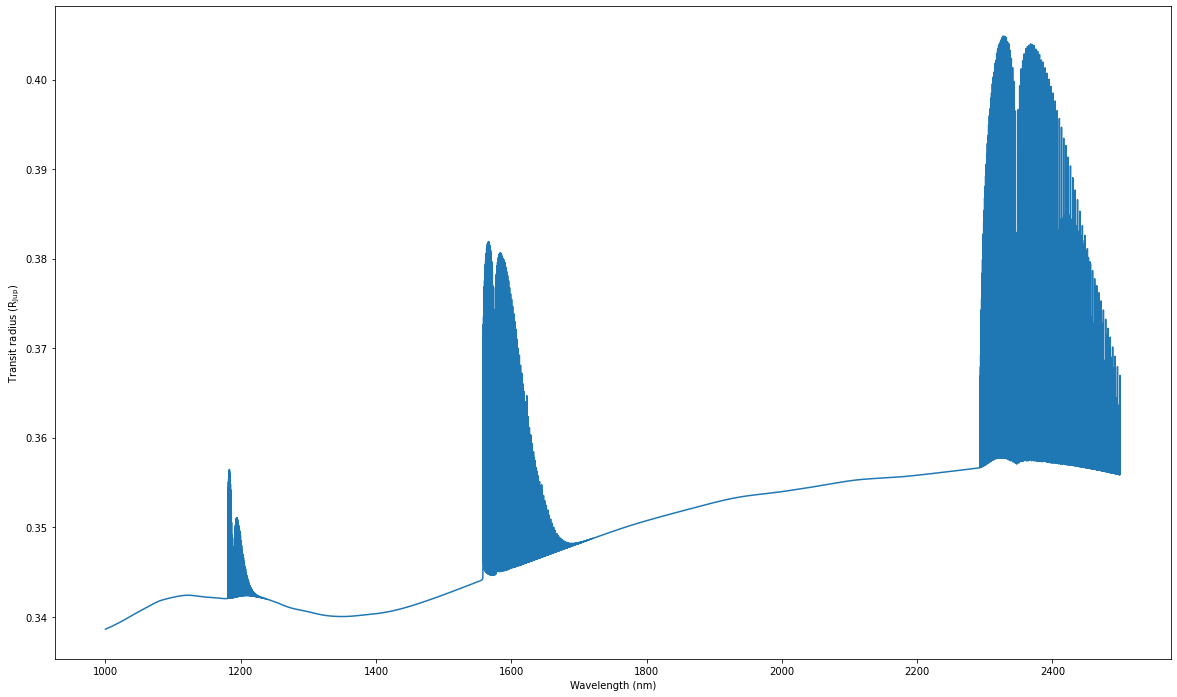

Transmission spectrum (Raw Flux):


<Figure size 432x288 with 0 Axes>

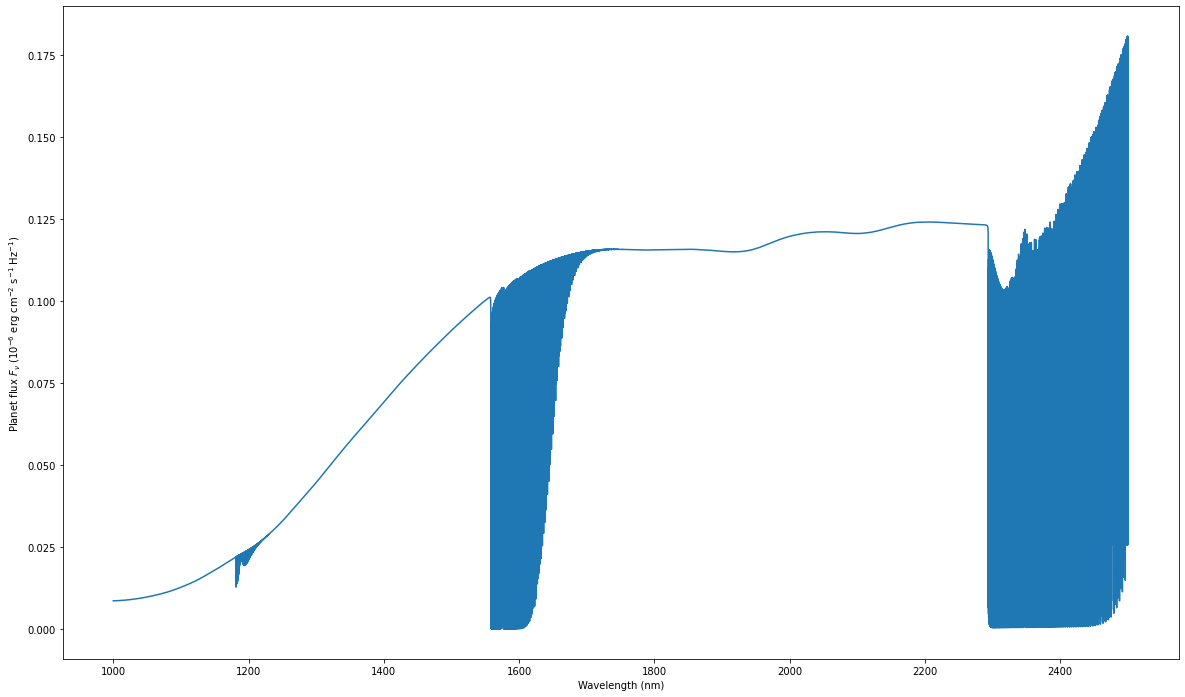

Unnormalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

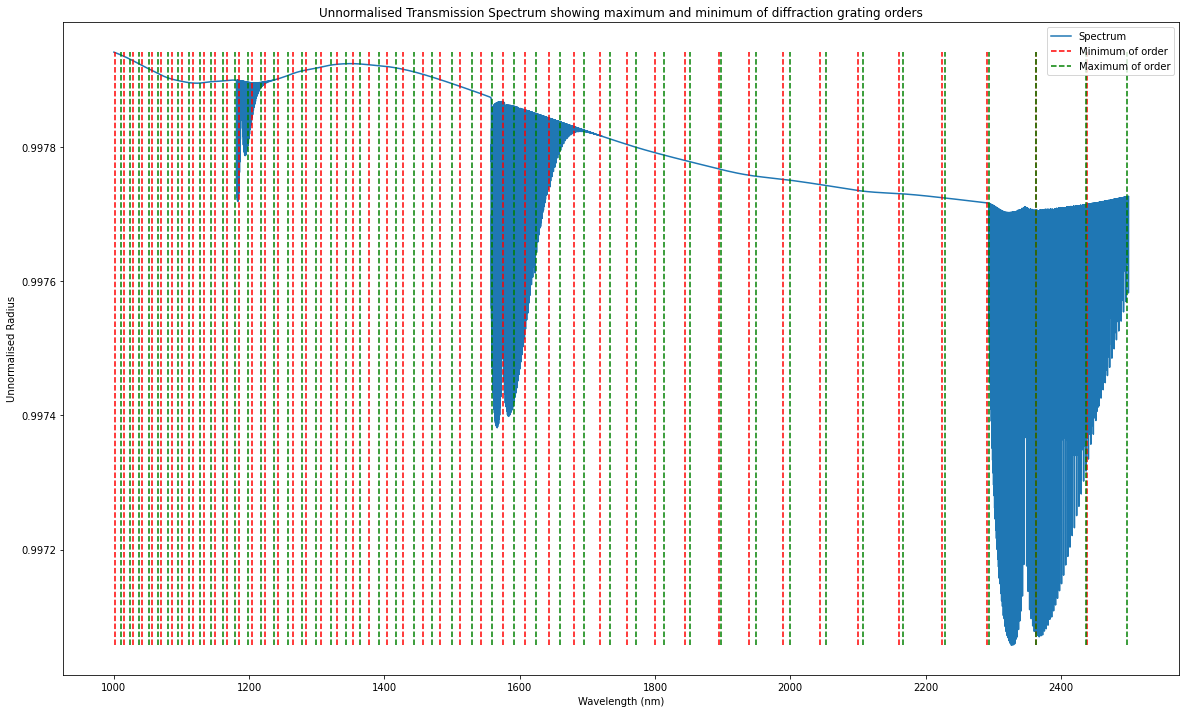

Normalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

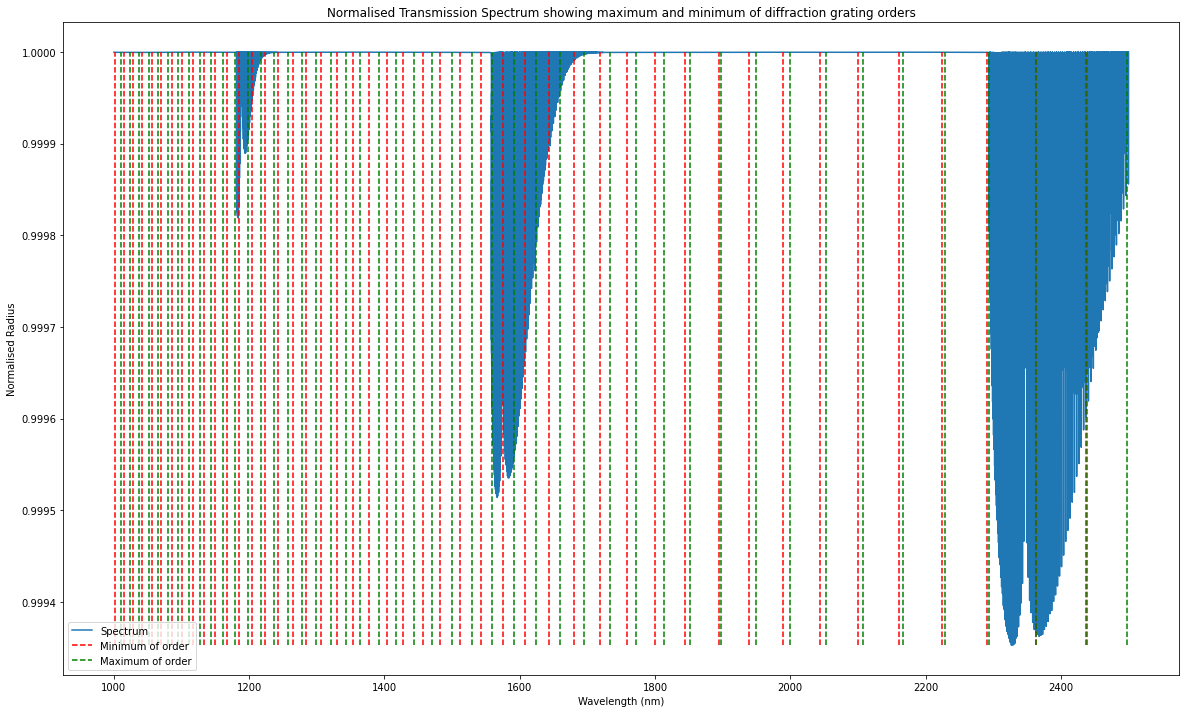

<Figure size 432x288 with 0 Axes>

In [3]:
LS        = ['CO_all_iso']
generate_spectra(LS, 1000, 2500, 'Guillot')

  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Plot of Transit radius:


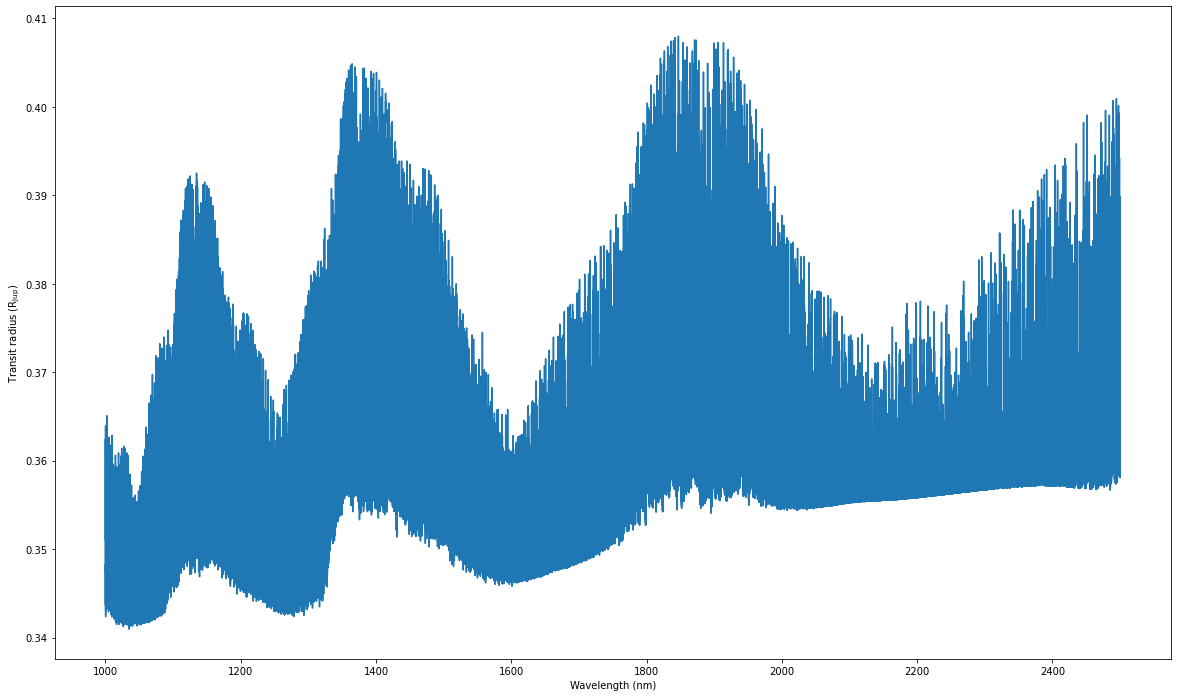

Transmission spectrum (Raw Flux):


<Figure size 432x288 with 0 Axes>

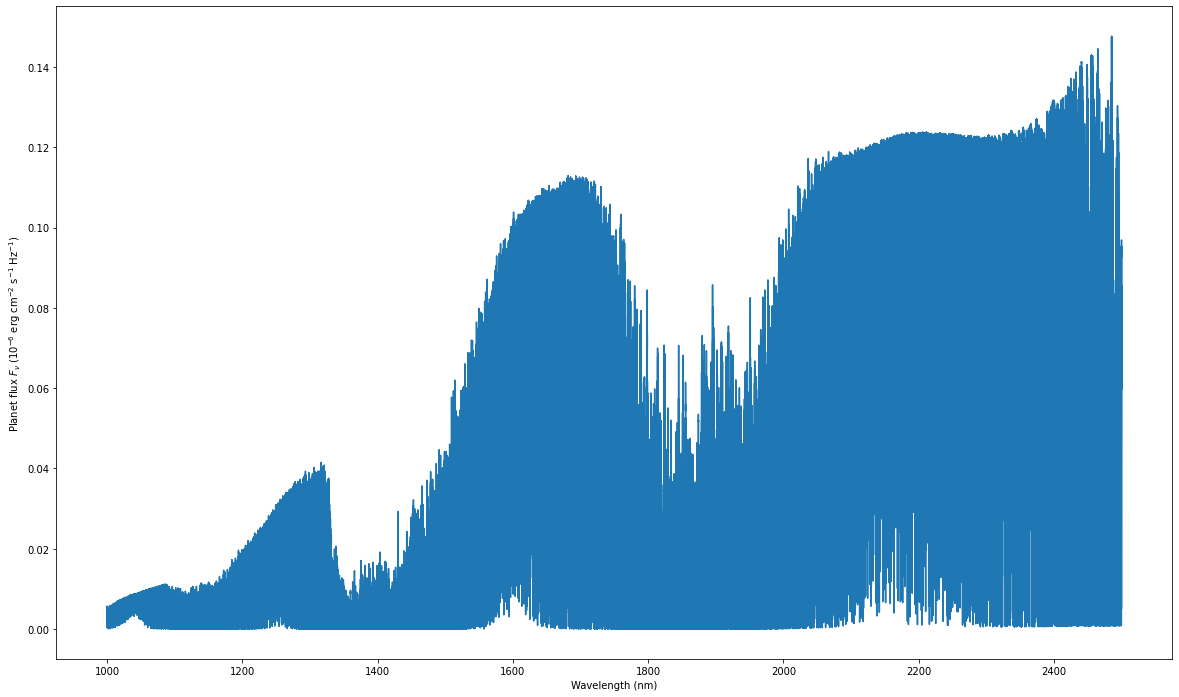

Unnormalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

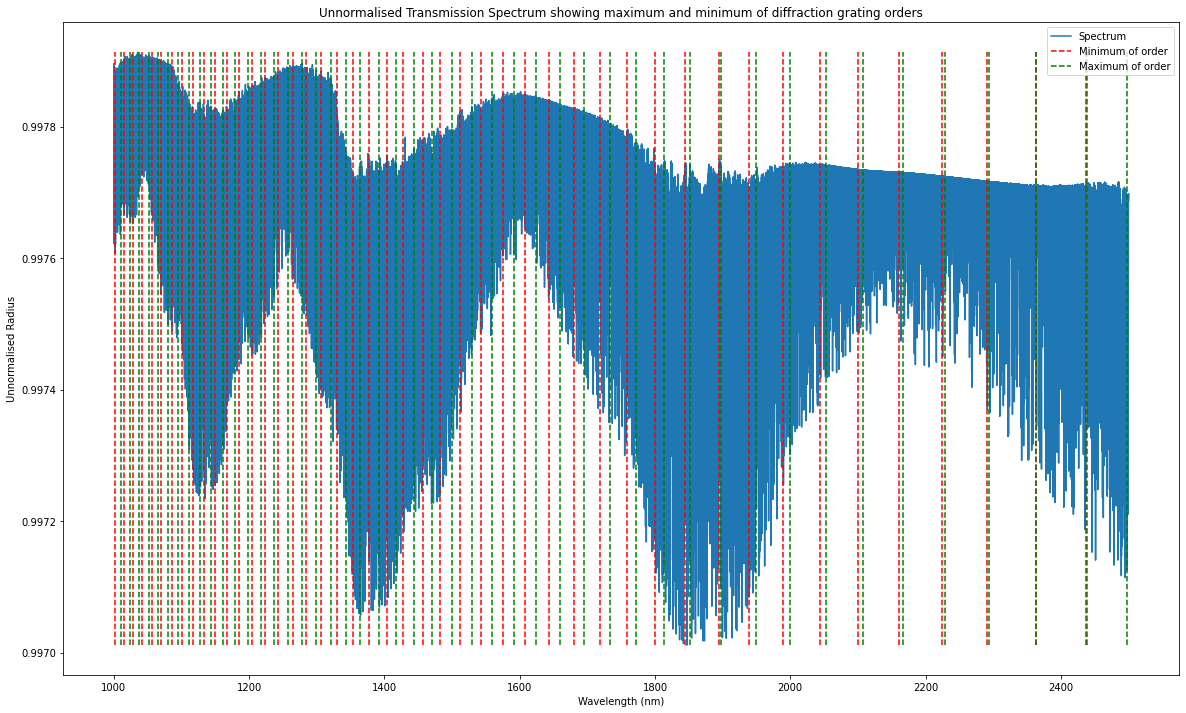

Normalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

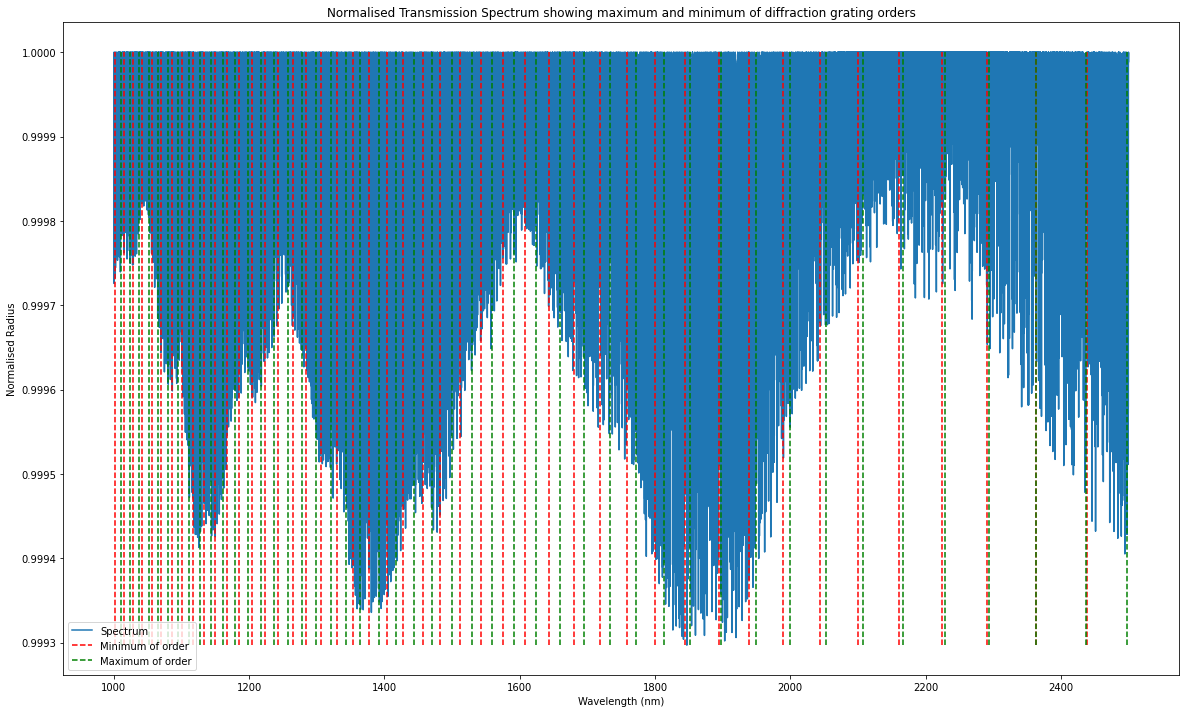

<Figure size 432x288 with 0 Axes>

In [4]:
LS        = ['H2O_main_iso']
generate_spectra(LS, 1000, 2500, 'Guillot')

  Read line opacities of CH4_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Plot of Transit radius:


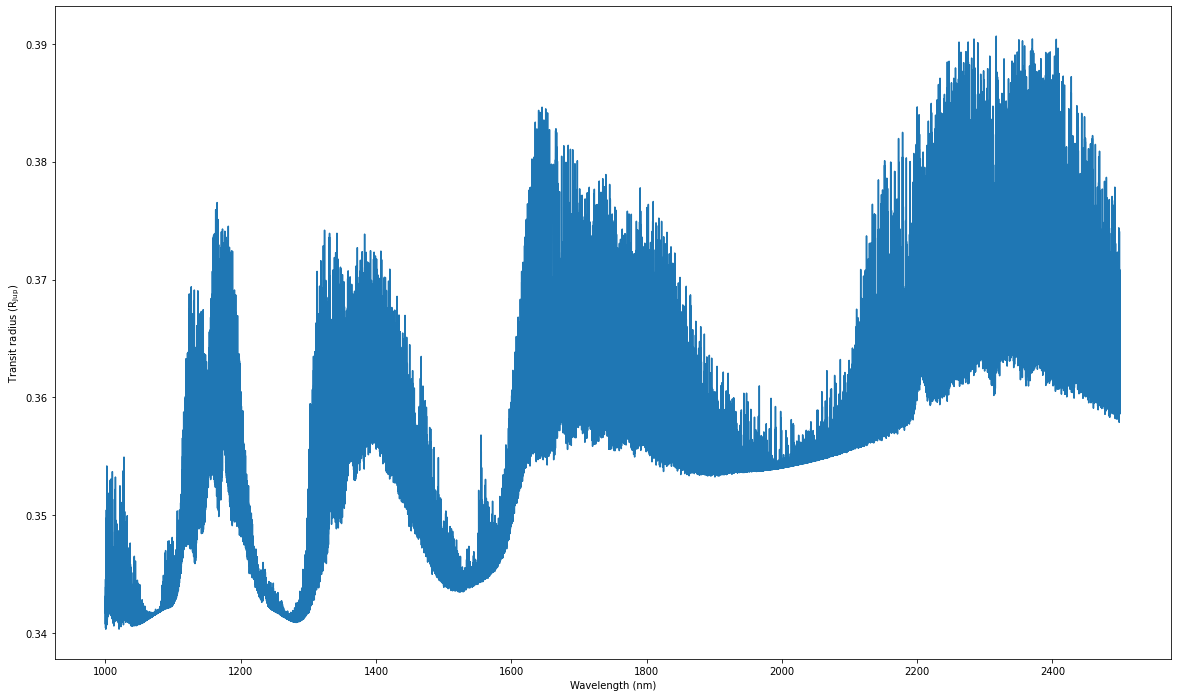

Transmission spectrum (Raw Flux):


<Figure size 432x288 with 0 Axes>

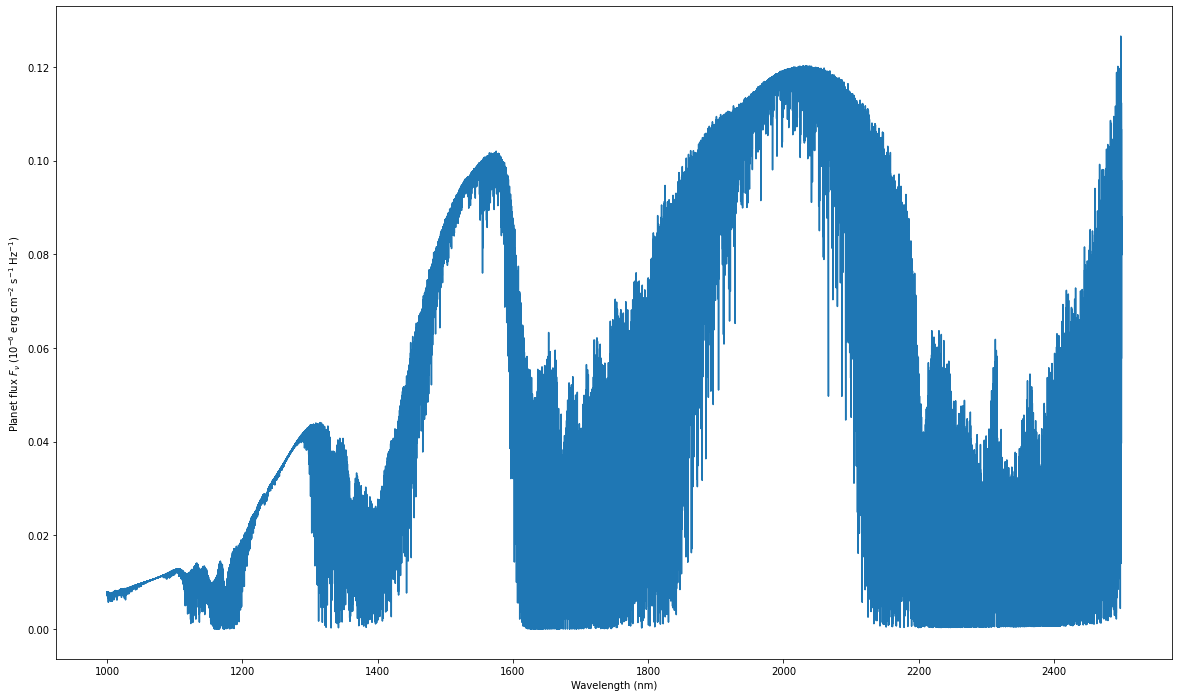

Unnormalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

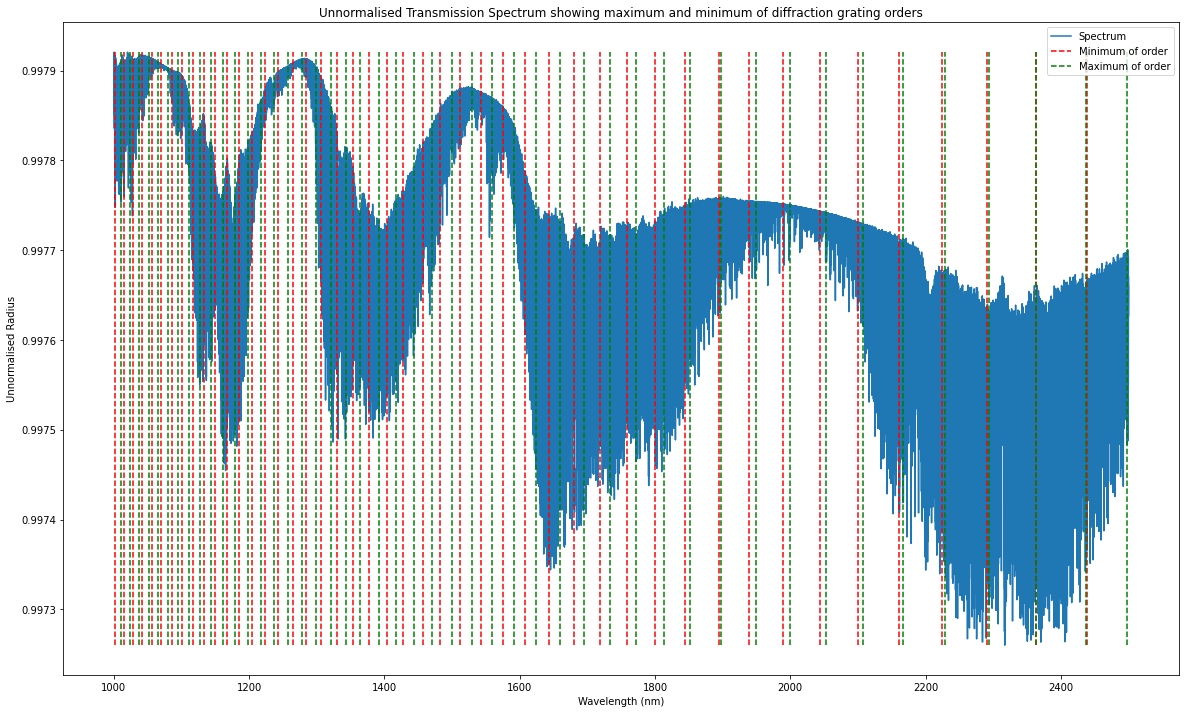

Normalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

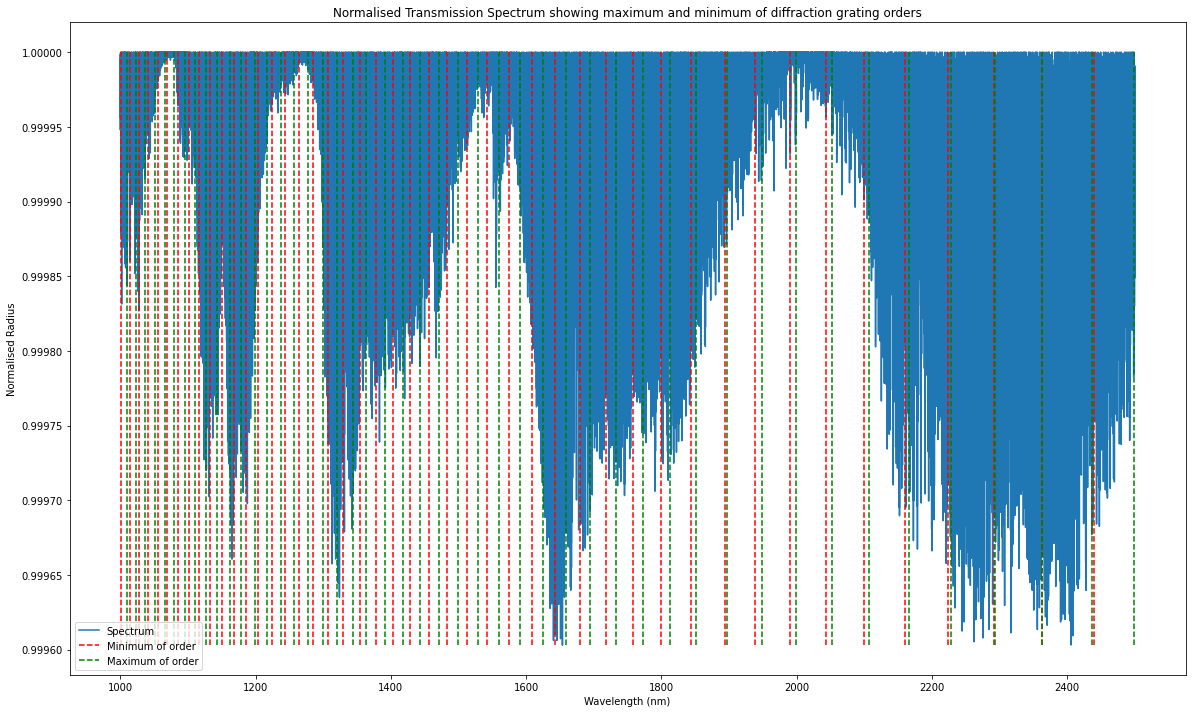

<Figure size 432x288 with 0 Axes>

In [5]:
LS        = ['CH4_main_iso']
generate_spectra(LS, 1000, 2500, 'Guillot')

  Read line opacities of NH3_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Plot of Transit radius:


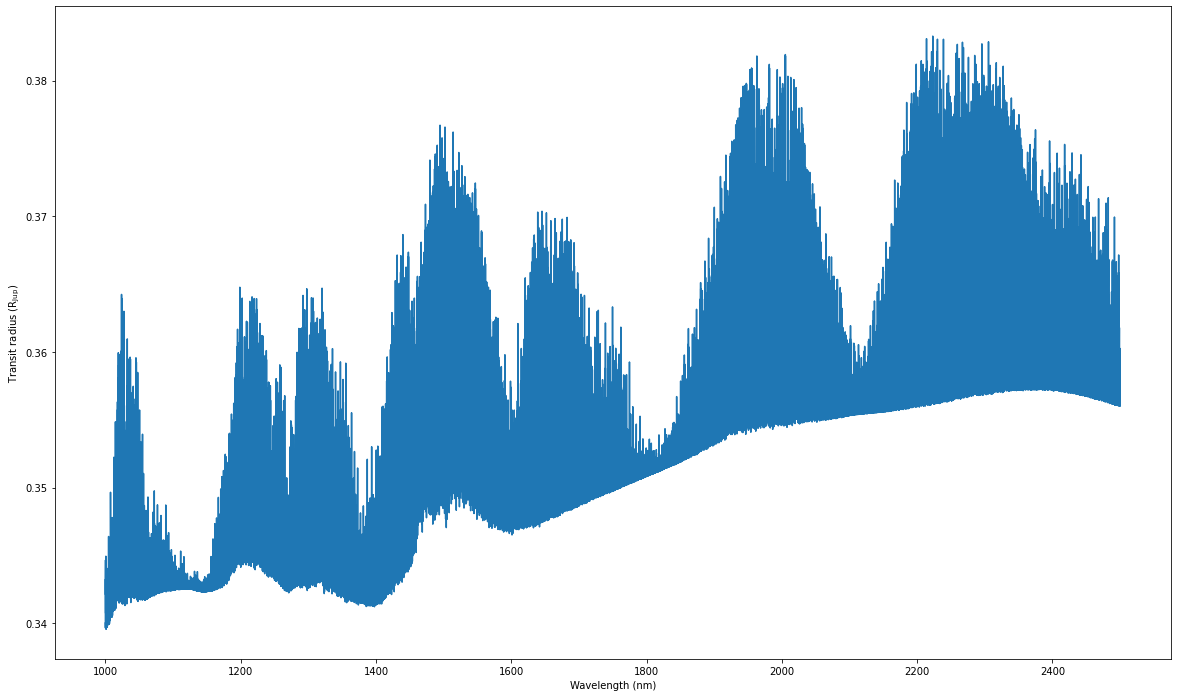

Transmission spectrum (Raw Flux):


<Figure size 432x288 with 0 Axes>

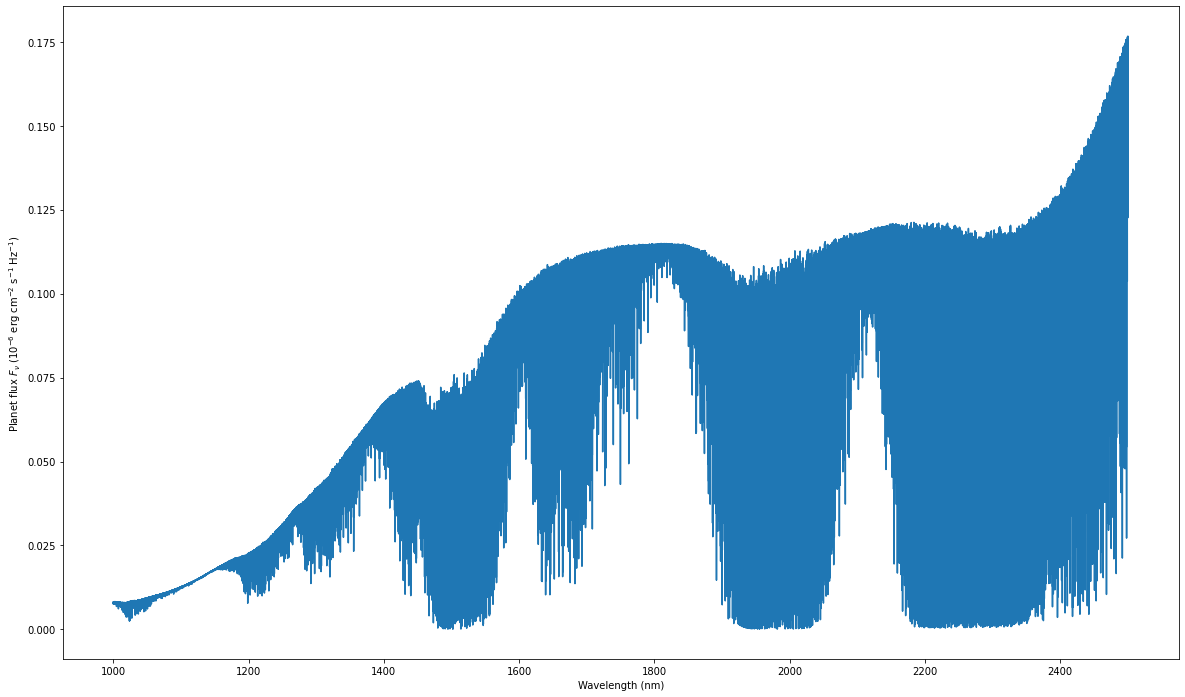

Unnormalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

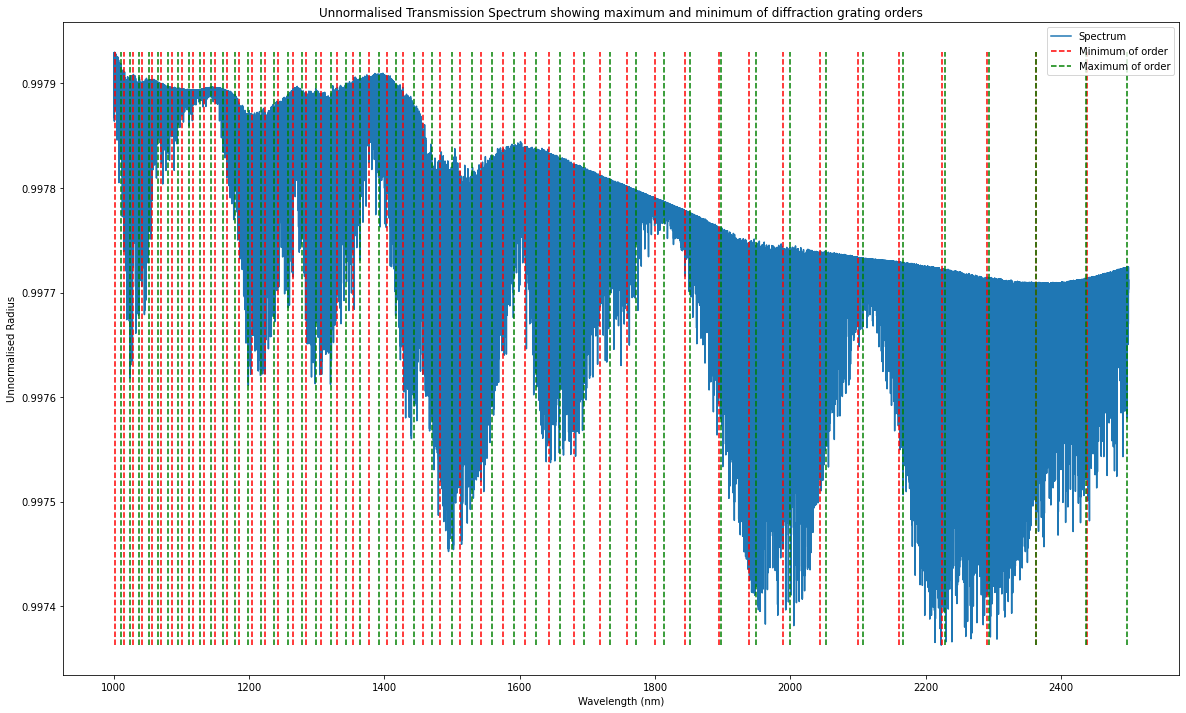

Normalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

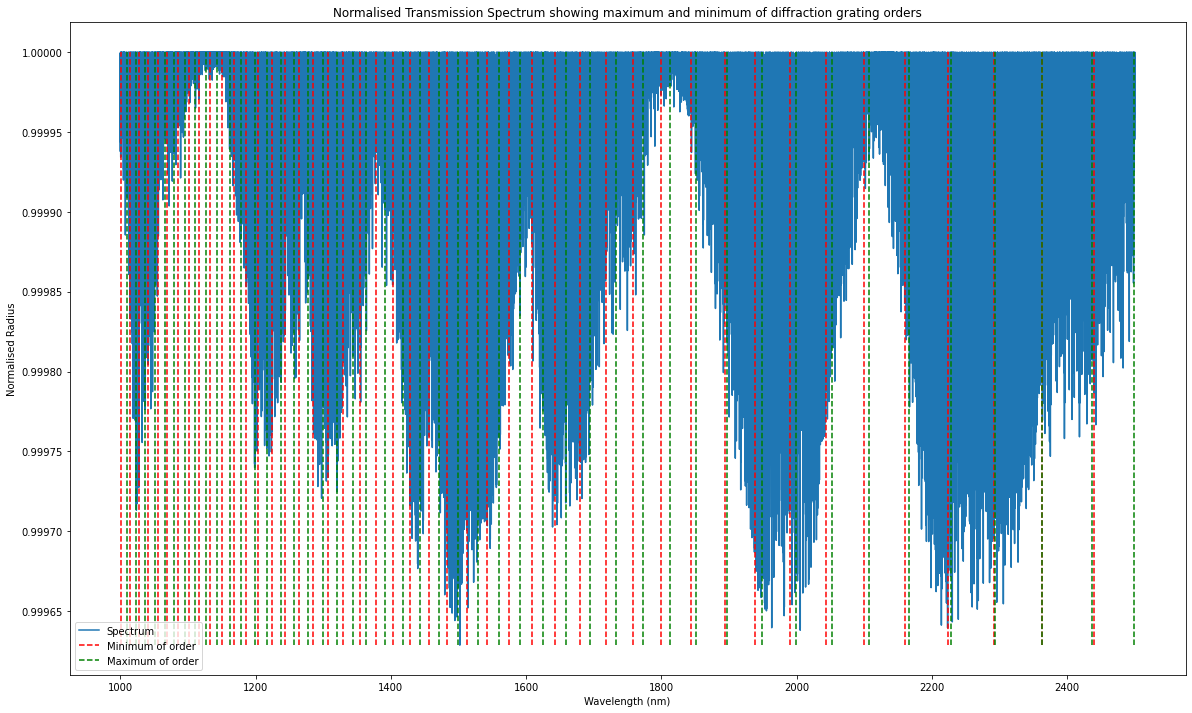

<Figure size 432x288 with 0 Axes>

In [6]:
#LS is a list containing all species to be simulated, available species (on my computer anyway) are below
#LS = ['H2O_main_iso','CO_all_iso','NH3_main_iso','CO2_main_iso','CH4_main_iso','HCN_main_iso', 'Na', 'K']

LS        = ['NH3_main_iso']

generate_spectra(LS, 1000, 2500, 'Guillot')


  Read line opacities of HCN_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Plot of Transit radius:


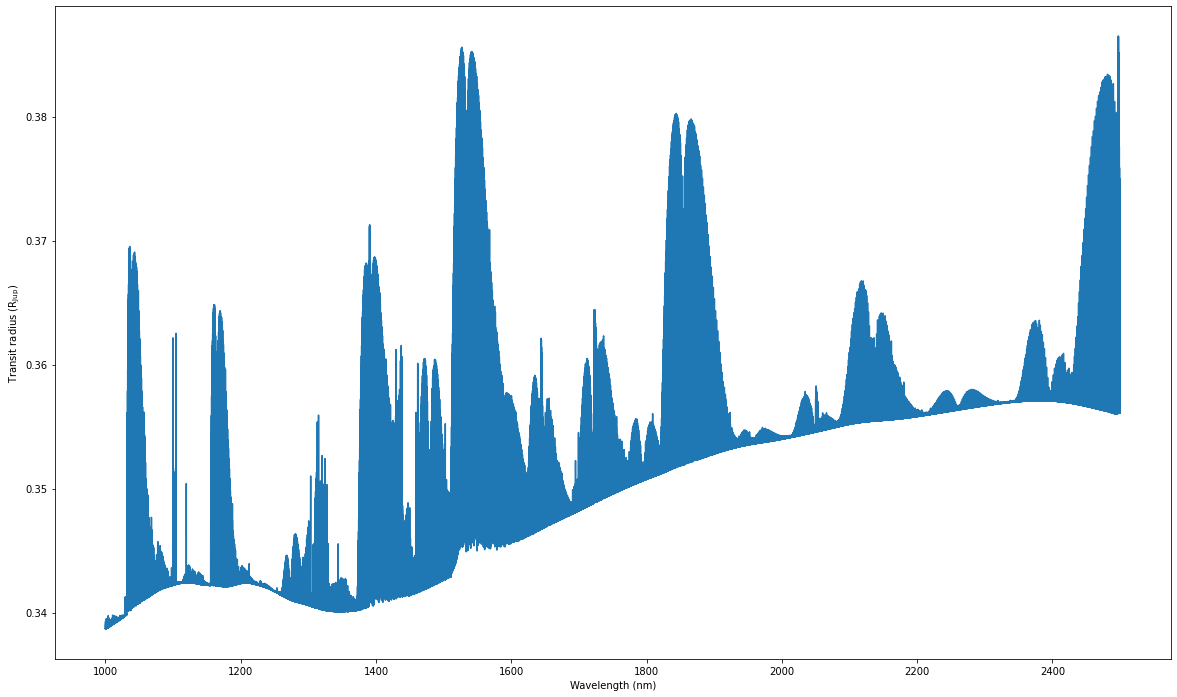

Transmission spectrum (Raw Flux):


<Figure size 432x288 with 0 Axes>

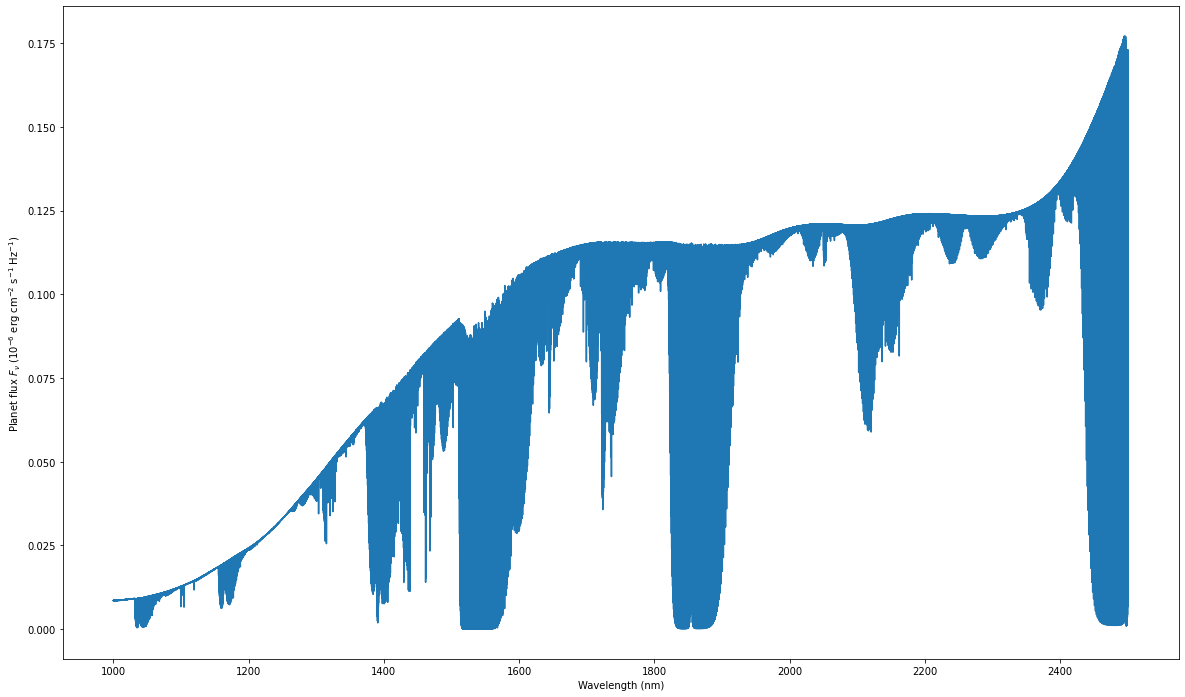

Unnormalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

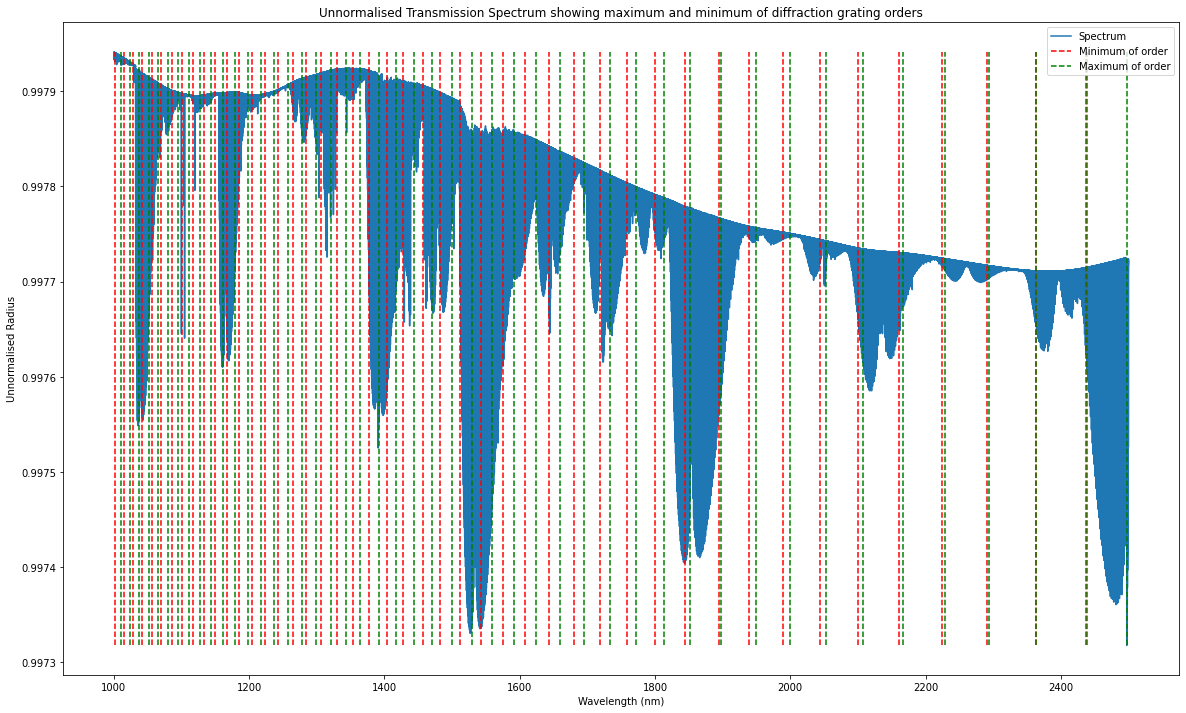

Normalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

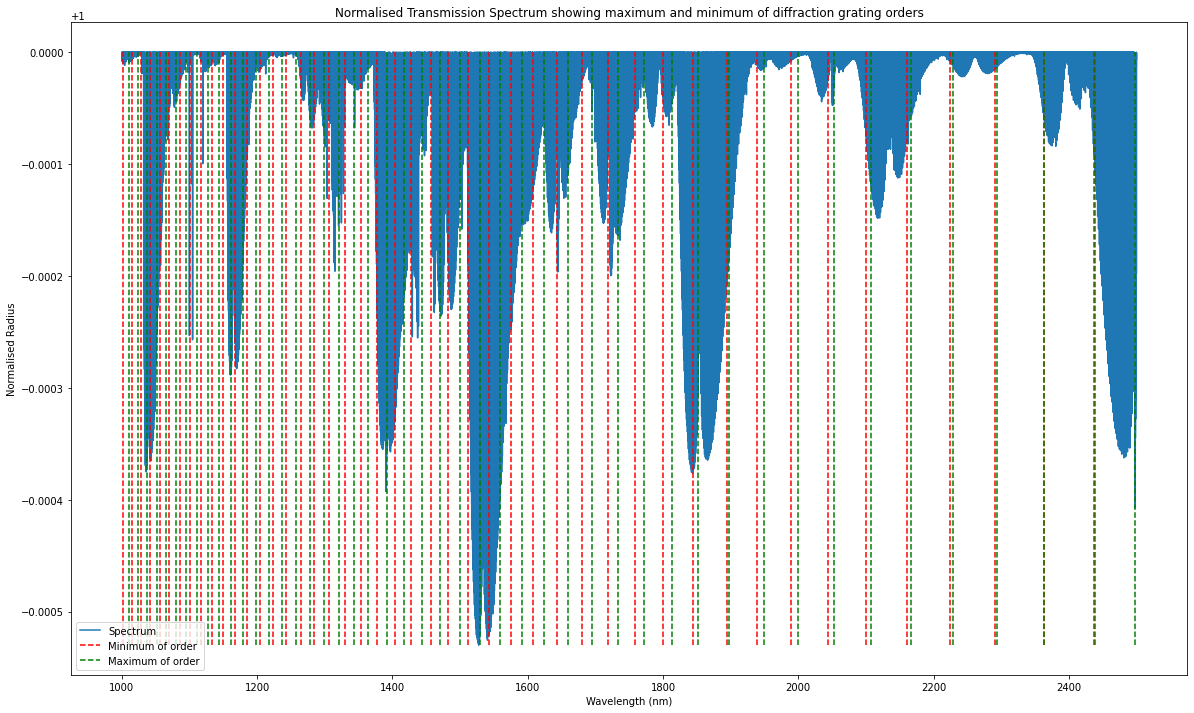

<Figure size 432x288 with 0 Axes>

In [7]:
LS        = ['HCN_main_iso']

generate_spectra(LS, 1000, 2500, 'Guillot')


  Read line opacities of CO2_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Plot of Transit radius:


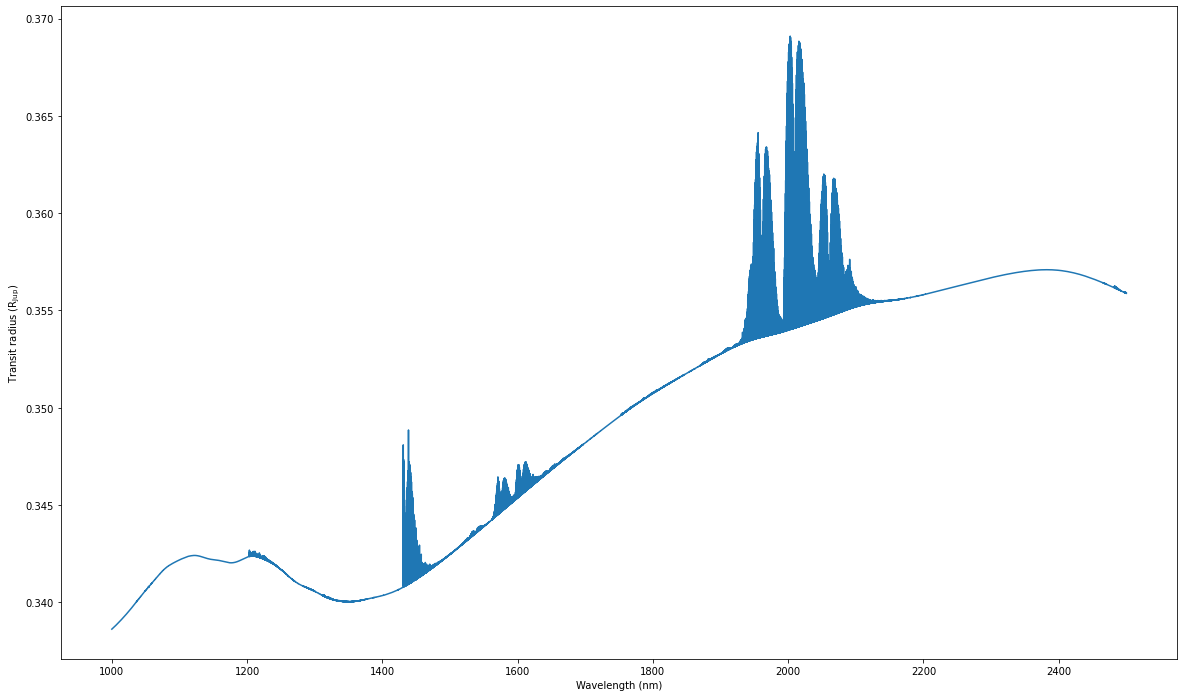

Transmission spectrum (Raw Flux):


<Figure size 432x288 with 0 Axes>

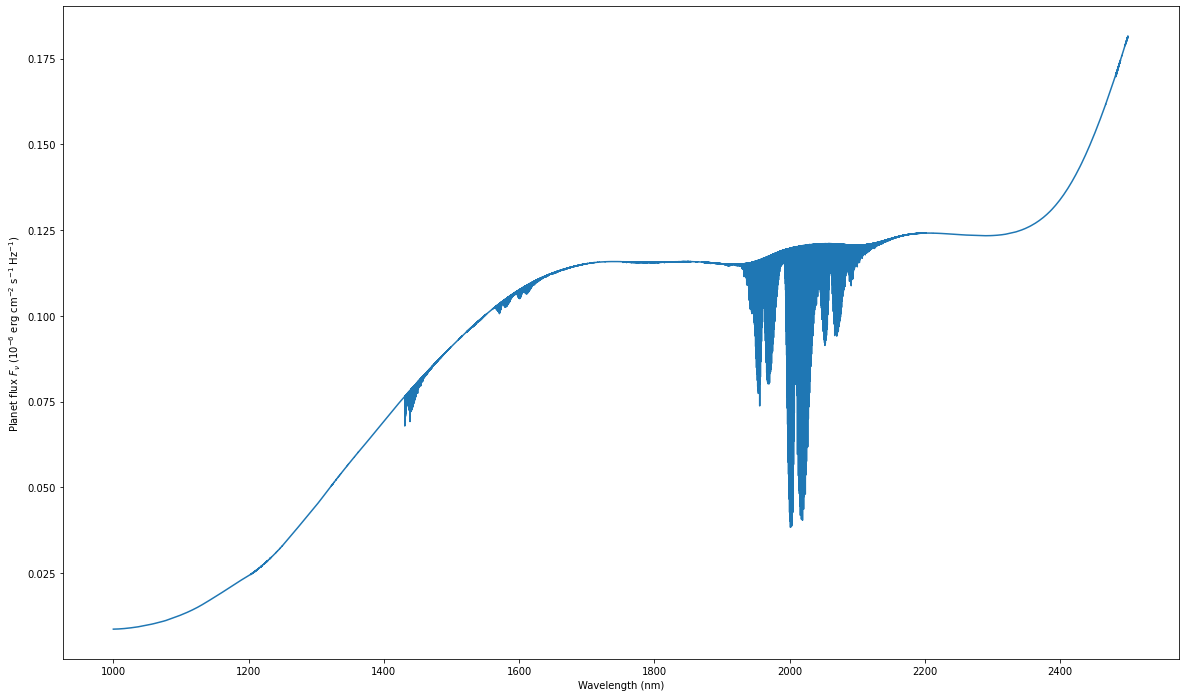

Unnormalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

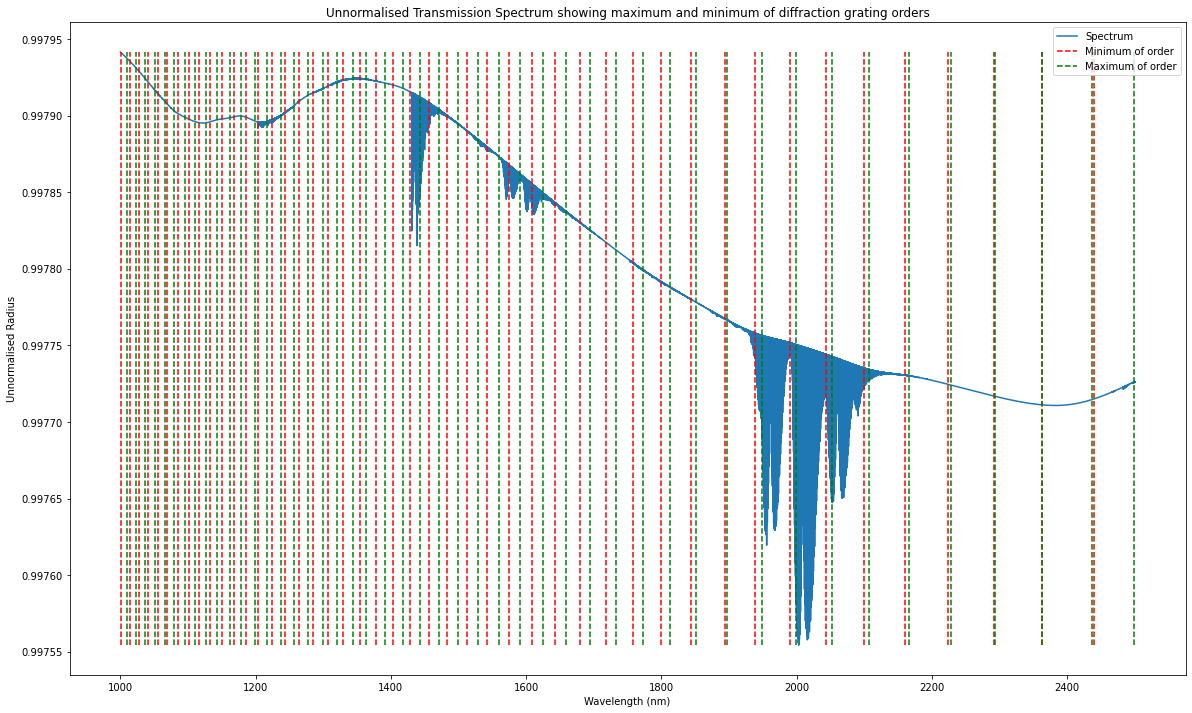

Normalised Transmission Spectrum


<Figure size 432x288 with 0 Axes>

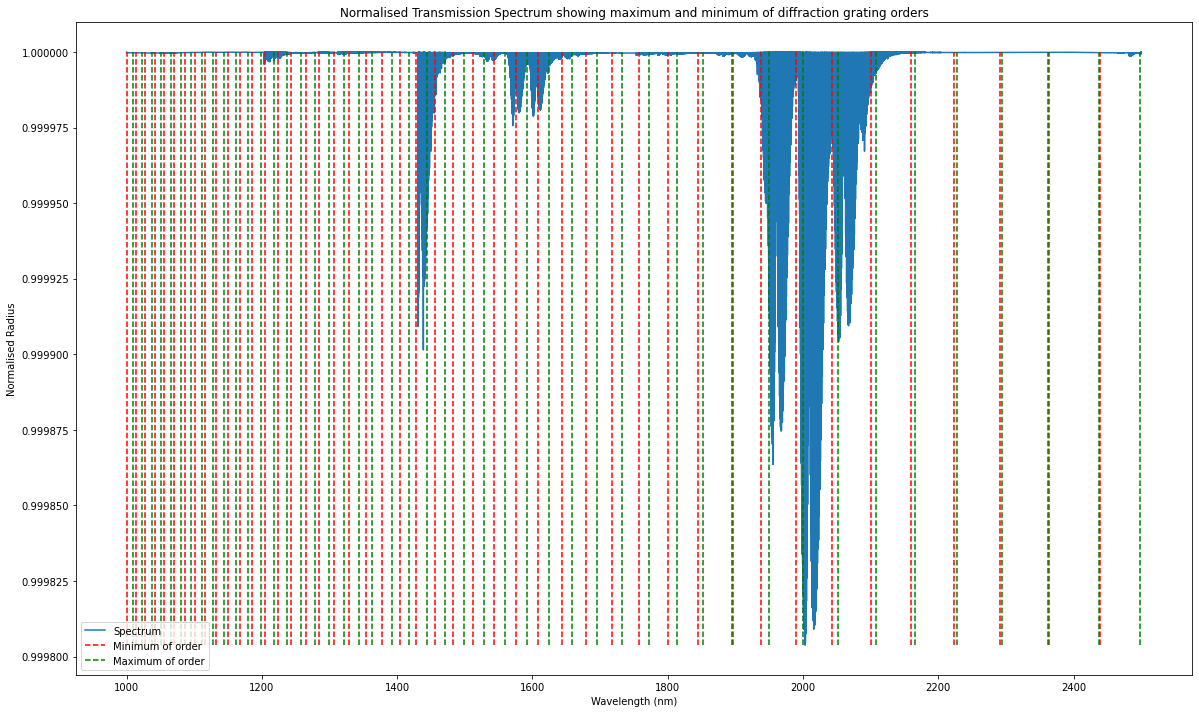

<Figure size 432x288 with 0 Axes>

In [8]:
LS        = ['CO2_main_iso']
generate_spectra(LS, 1000, 2500, 'Guillot')

# Tuning T,P Profile

In [2]:
T_equ = 593. 
#T_equ is well constrained so no need - for AU Mic b at least - to have T_equ as an input parameter.
#T_int is less well known so have put as a input if desired. 


def PT_profile(conditions, T_int=200):
    for cond in conditions:
        gamma = cond[0]
        kappa_IR = cond[1]
        temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)
        plt.plot(temperature, pressures, label=cond[2] + ", " r'$\gamma$ =' + str(gamma) + ", " r'$\kappa_{IR}$ =' + str(kappa_IR))
        plt.rcParams['figure.figsize'] = (20, 12)
        plt.yscale('log')
        plt.xlim([400,1600])
        plt.ylim([1e2, 1e-6])
        plt.tick_params(labelright=True, right=True)
        plt.xlabel('T (K)')
        plt.ylabel('P (bar)')
    plt.legend(prop={'size': 15})    
    plt.show()
    plt.clf()
    
#Conditions should be a list/list of lists for multiple conditions
#conditions = [gamma, kappa_IR, label (e.g. Cool/Moderate/Warm)]

    

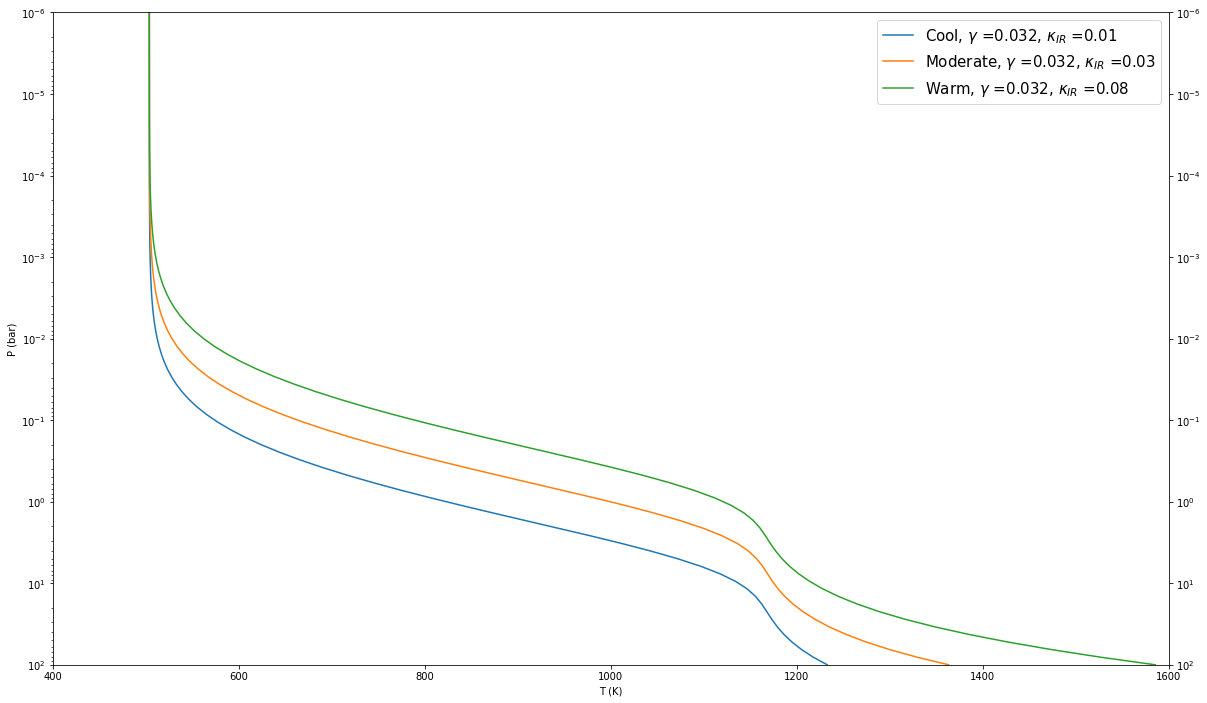

<Figure size 1440x864 with 0 Axes>

In [172]:
#Varying kappa_IR
conditions= [[0.032, 0.01, 'Cool'], [0.032, 0.03, 'Moderate'], [0.032, 0.08, 'Warm']]
PT_profile(conditions)

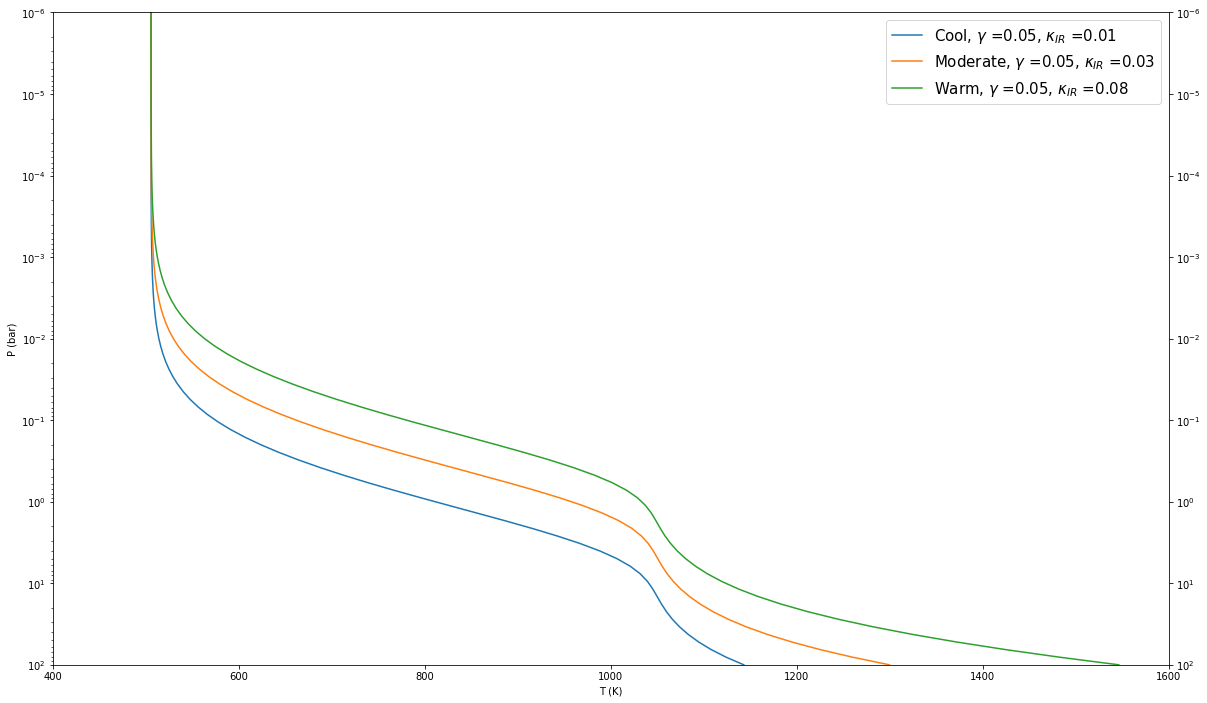

<Figure size 1440x864 with 0 Axes>

In [173]:
#Varying kappa_IR for higher gamma
conditions= [[0.05, 0.01, 'Cool'], [0.05, 0.03, 'Moderate'], [0.05, 0.08, 'Warm']]
PT_profile(conditions)

In [177]:
#Varying kappa_IR for higher gamma
#conditions= [[0.1, 0.01, 'Cool'], [0.1, 0.03, 'Moderate'], [0.1, 0.08, 'Warm']]
#PT_profile(conditions)

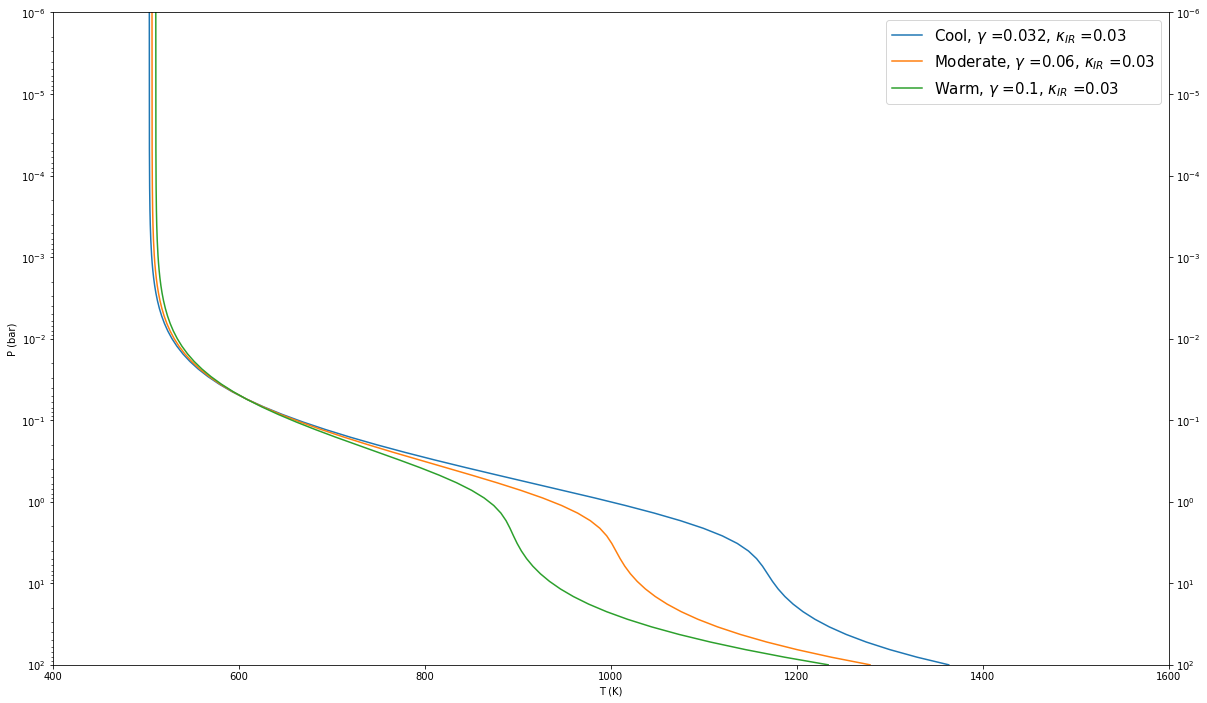

<Figure size 1440x864 with 0 Axes>

In [5]:
#Varying gamma:
conditions = [[0.032, 0.03, 'Cool'], [0.06,0.03,'Moderate'] ,[0.1,0.03, 'Warm']]
PT_profile(conditions)

## Bringing the previous code together to generate atmosphere based on test models:

In [23]:
import numpy as np
import time
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
import pylab as plt
import scipy
from scipy import ndimage
import csv

# ----------------------------------------------------------------------------------------------------------- #
####### PARAMETERS -- USER INPUT -- VALUES BELOW ARE FOR AU Mic b
# ----------------------------------------------------------------------------------------------------------- #

Rp        = 0.363*nc.r_jup_mean     # Planet radius [cm] 
Rs        = 0.75*nc.r_sun           # Stellar radius [cm] (planet and stellar radius from: https://arxiv.org/abs/2006.13248) 
Mass      = 11.7*nc.m_earth         # Planet mass [g] (mass estimate from: https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.3060Z/abstract)
gravity   = (nc.G*Mass)/(Rp**2)     # Planet surface gravity [cgs]
P0        = 0.01                    # Reference pressure [bar]
Teq       = 593                    # Planet equilibrium temperature [K] -- Isothermal model
#fact      = 0.01                   # Multiplicative factor to extend the wavelength ranges for petitRADTRANS
                                   # e.g., fact = 0.01 means that the wavelength range is 1% larger than the  min/max wavelengths in the input wave file

    
#Guillot Temperature profile parameters - should prob leave these as an input for function
#kappa_IR = 0.01                    # Atmospheric opacity in IR wavelengths (cross-section per unit mass)
#gamma = 0.4                        # Ratio between optical and IR opacity 
#T_int = 200.                       # Planetary internal temperature [K] -- Guillot model
#T_equ = 1500.                      # Atmospheric Equilibrium Temperature (External) [K] -- Guillot model
    
    


In [ ]:
def calculate_abundances(metallicity, C_O_ratio):
    #Take the params and calculate the relative mass fractions of the elemental species - then the molecules
    #calculate MMW 
    #store the results in a list(?) and input these into the pRT code for next function
    
    
    #abundance data from table 3 of https://link.springer.com/article/10.1007/s11214-021-00825-8
    #Using the file here allows for easy addition of other elements and species, just need to adapt the equations
    # that calculate relative abundances 

In [6]:
#Input atmospheric metallicities of planet to test, in units of solar metallicities:
metallicities = [1, 10, 100, 1000, 10000]

#Input atmospheric C/O ratios (by number) to test:
C_O_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 1]



#make function which does everything (plots, norm etc), then:
#make nested for loop to iterate over each metallicity and c/o ratio - call the function for each iteration and
#generate results - unless this will take too long/produce too much



In [74]:
#.csv file of Table 3 of Lodder 2021 showing the solar elemental abundances
#Input elements that we are interested in: here H, He, C and O
#absolute_number_solar will be filled with the absolute number of each atom in 'elements' for every 10^6 Si atoms

elements = ['H', 'He', 'C', 'O']
solar_element_abundance = []
with open('solar_elemental_abundances.csv') as solar_values:
    lines = solar_values.readlines()[3:]
    for row in lines:
        values = row.split(',')
        if values[1] in elements:
            solar_element_abundance.append(float(values[6]))